In [14]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
data_dir = 'gc10detold'
class_names = sorted([subdir for subdir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subdir))])
num_classes = len(class_names)
data_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


In [16]:
train_data_gen = data_gen.flow_from_directory(directory=data_dir,
                                              target_size=(224, 224),
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=123,
                                              subset='training')


Found 2549 images belonging to 11 classes.


In [17]:
val_data_gen = data_gen.flow_from_directory(directory=data_dir,
                                              target_size=(224, 224),
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=123,
                                              subset='validation')

Found 632 images belonging to 11 classes.


Text(0.5, 0.98, 'Sample images for 11 classes')

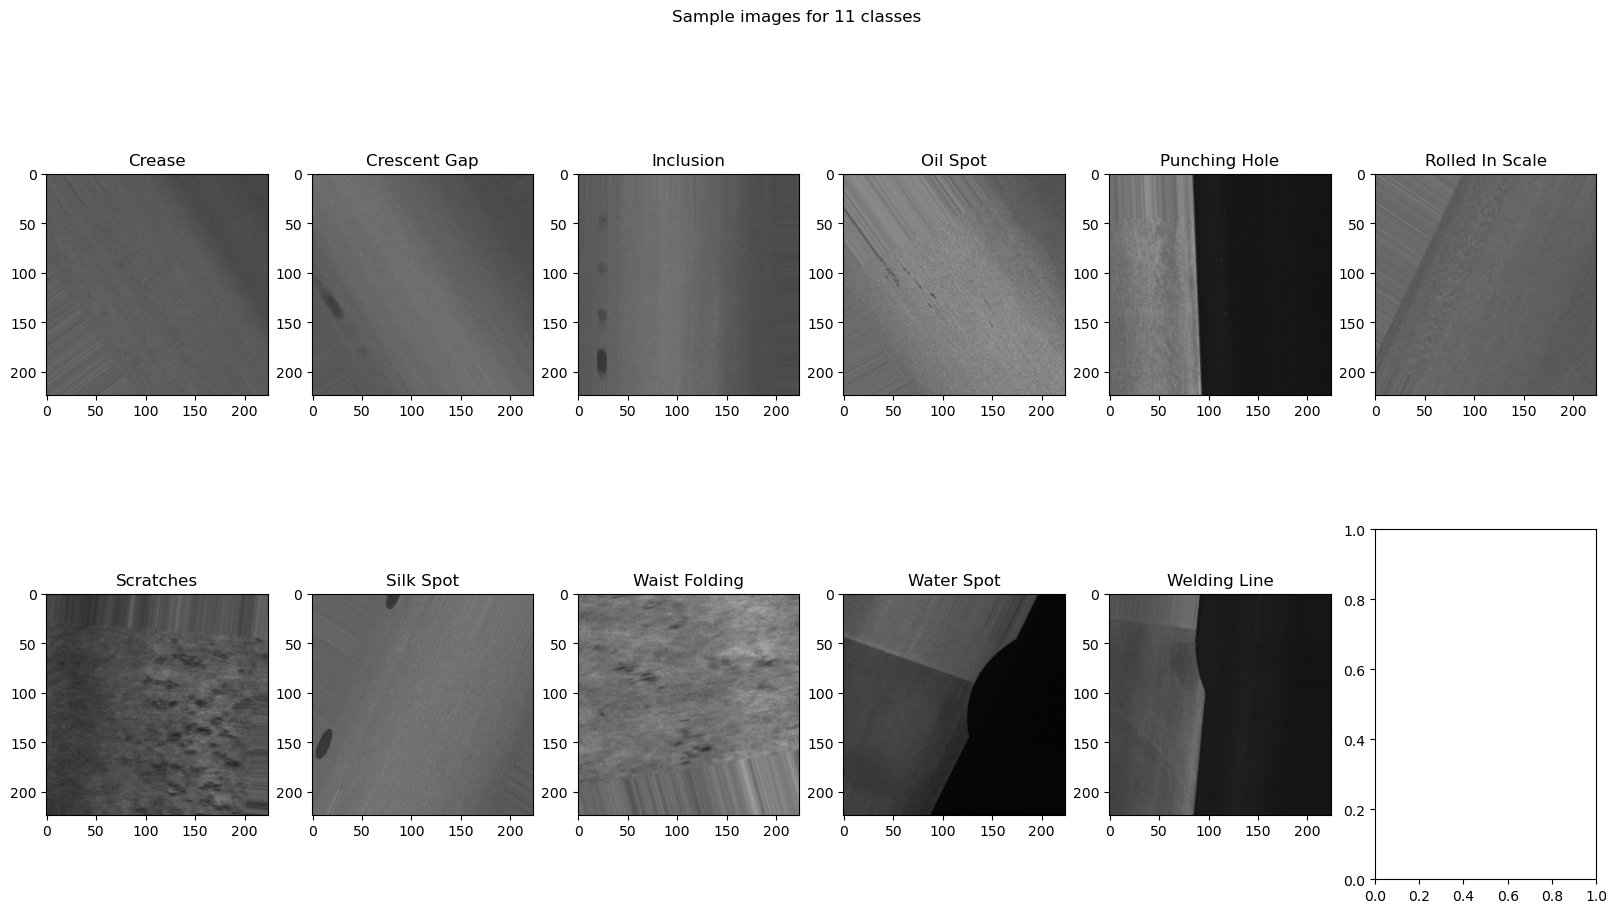

In [18]:
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
axs = axs.ravel()
class_names = [name.replace("_", " ").title() for name in class_names]
for i in range(num_classes):
    images, labels = val_data_gen.next()
    axs[i].imshow(images[0])
    axs[i].set_title(class_names[i])
    axs[i].grid(False)
fig.suptitle(f"Sample images for {num_classes} classes")

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))

model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(train_data_gen.num_classes, activation='softmax')
])

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
# Define the early stopping and model checkpoint callbacks
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min'),
keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_loss', mode='min')]

# # Unfreeze the last few layers of the base model
for layer in base_model.layers[-10:]:
      layer.trainable = False

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                22539     
Total params: 21,825,323
Trainable params: 21,790,699
Non-trainable params: 34,624
_________________________________________________________________


In [22]:
history = model.fit(
    train_data_gen,
    epochs=30,
    validation_data=val_data_gen,
    callbacks=False
)

Epoch 1/30
80/80 [==============================] - 163s 2s/step - loss: 1.5070 - accuracy: 0.5269 - val_loss: 1.4910 - val_accuracy: 0.4953
Epoch 2/30
80/80 [==============================] - 103s 1s/step - loss: 0.8197 - accuracy: 0.7450 - val_loss: 1.1160 - val_accuracy: 0.6361
Epoch 3/30
80/80 [==============================] - 108s 1s/step - loss: 0.6311 - accuracy: 0.7991 - val_loss: 0.8770 - val_accuracy: 0.6915
Epoch 4/30
80/80 [==============================] - 106s 1s/step - loss: 0.5361 - accuracy: 0.8325 - val_loss: 0.8951 - val_accuracy: 0.7057
Epoch 5/30
80/80 [==============================] - 105s 1s/step - loss: 0.5050 - accuracy: 0.8301 - val_loss: 0.7975 - val_accuracy: 0.7358
Epoch 6/30
80/80 [==============================] - 103s 1s/step - loss: 0.4359 - accuracy: 0.8564 - val_loss: 0.9257 - val_accuracy: 0.7136
Epoch 7/30
80/80 [==============================] - 104s 1s/step - loss: 0.4301 - accuracy: 0.8533 - val_loss: 0.9005 - val_accuracy: 0.7057
Epoch 8/30
80

In [30]:
test_loss, test_acc = model.evaluate(val_data_gen)
print('Test accuracy:', test_acc)

20/20 [==============================] - 20s 986ms/step - loss: 0.8731 - accuracy: 0.7642
Test accuracy: 0.7642405033111572


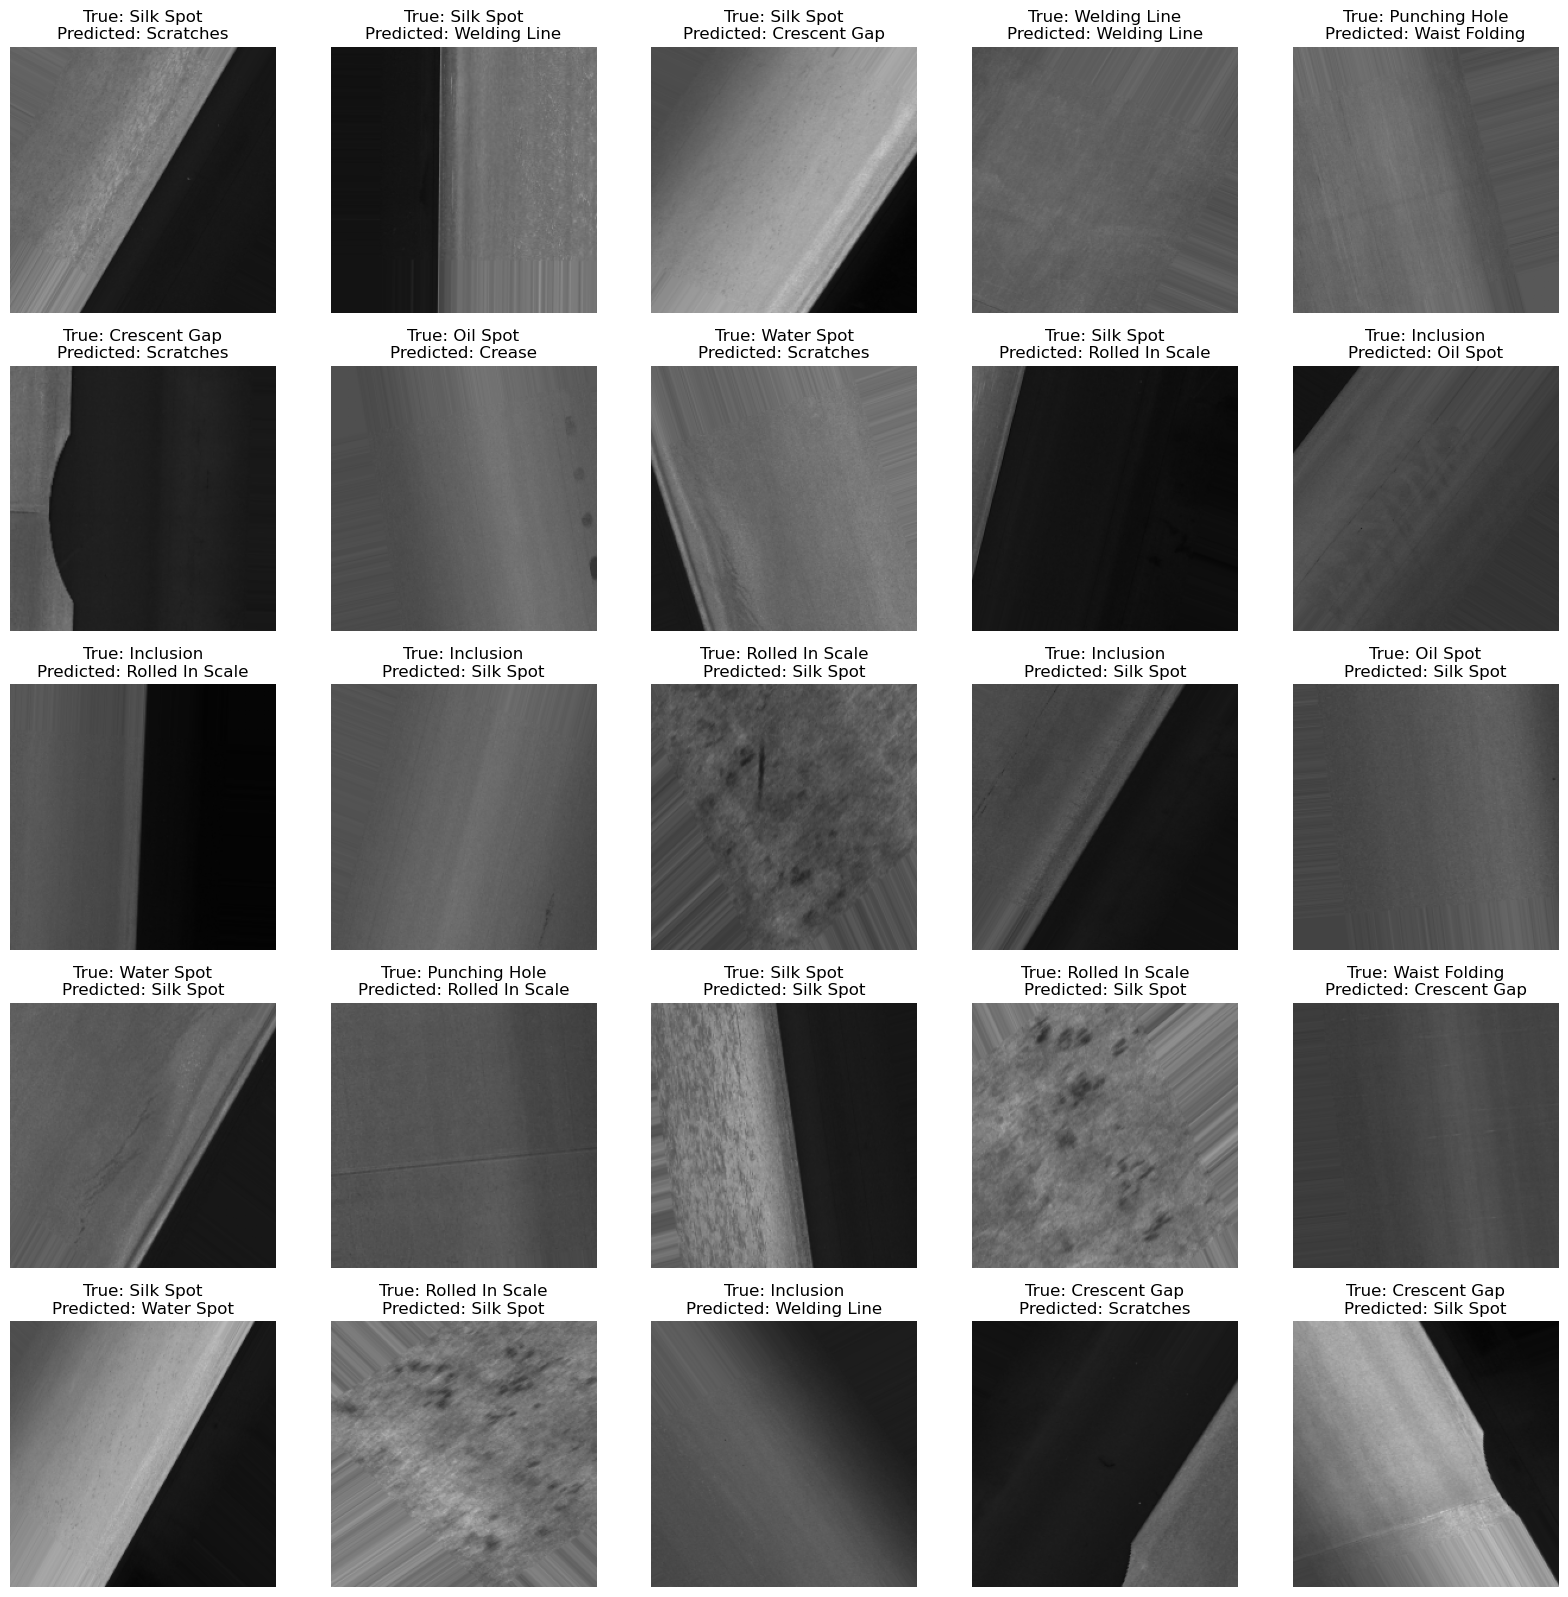

Total correct predictions: 2


In [31]:
predictions = model.predict(val_data_gen)
predicted_classes = np.argmax(predictions, axis=-1)
fig = plt.figure(figsize=(20, 20))
correct_prediction = 0
for i, image in enumerate(val_data_gen):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(image[0][0])
    ax.axis('off')
    ax.set_title(f"True: {class_names[np.argmax(image[1])]}\nPredicted: {class_names[predicted_classes[i]]}")
    if class_names[np.argmax(image[1])]==class_names[predicted_classes[i]]:
        correct_prediction += 1
    if i == 24:
        break
plt.show()
print(f"Total correct predictions: {correct_prediction}")

In [32]:
model.save("InceptionV3-30.h5")

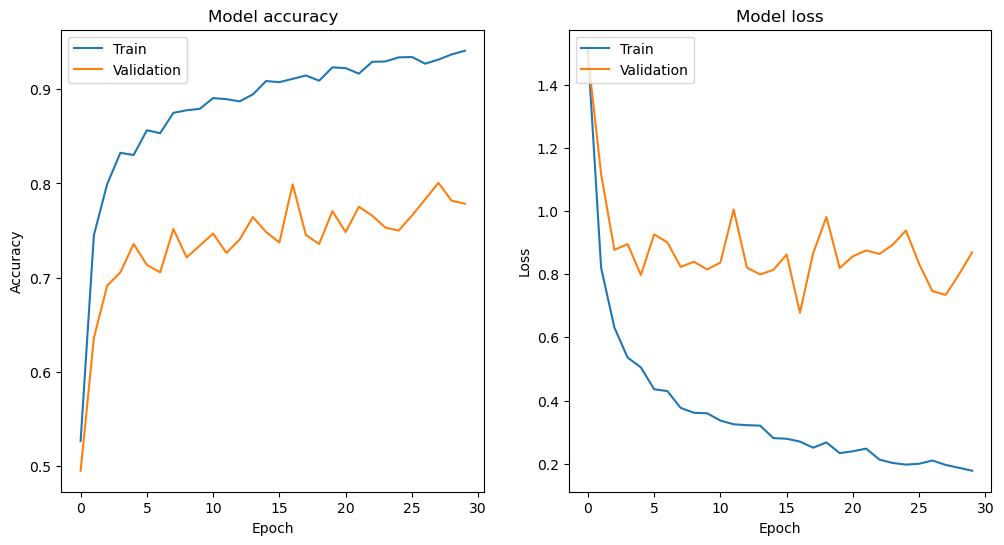

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [34]:
from sklearn.svm import SVC

# Extract features using InceptionV3
train_features = base_model.predict(train_data_gen, verbose=1)
val_features = base_model.predict(val_data_gen, verbose=1)

20/20 [==============================] - 20s 981ms/step


In [35]:
train_features_flat = train_features.reshape(train_features.shape[0], -1)

In [36]:
# Train an SVM classifier on the extracted features
svm = SVC(C=1, gamma=0.1, kernel='rbf')
svm.fit(train_features_flat, train_data_gen.labels)

SVC(C=1, gamma=0.1)

In [37]:
# Evaluate the SVM classifier on the validation set
val_features_flat = val_features.reshape(val_features.shape[0], -1)
svm_accuracy = svm.score(val_features_flat, val_data_gen.labels)
print('SVM accuracy:', svm_accuracy)

SVM accuracy: 0.20569620253164558


In [38]:
svm_predictions = svm.predict(val_features_flat)

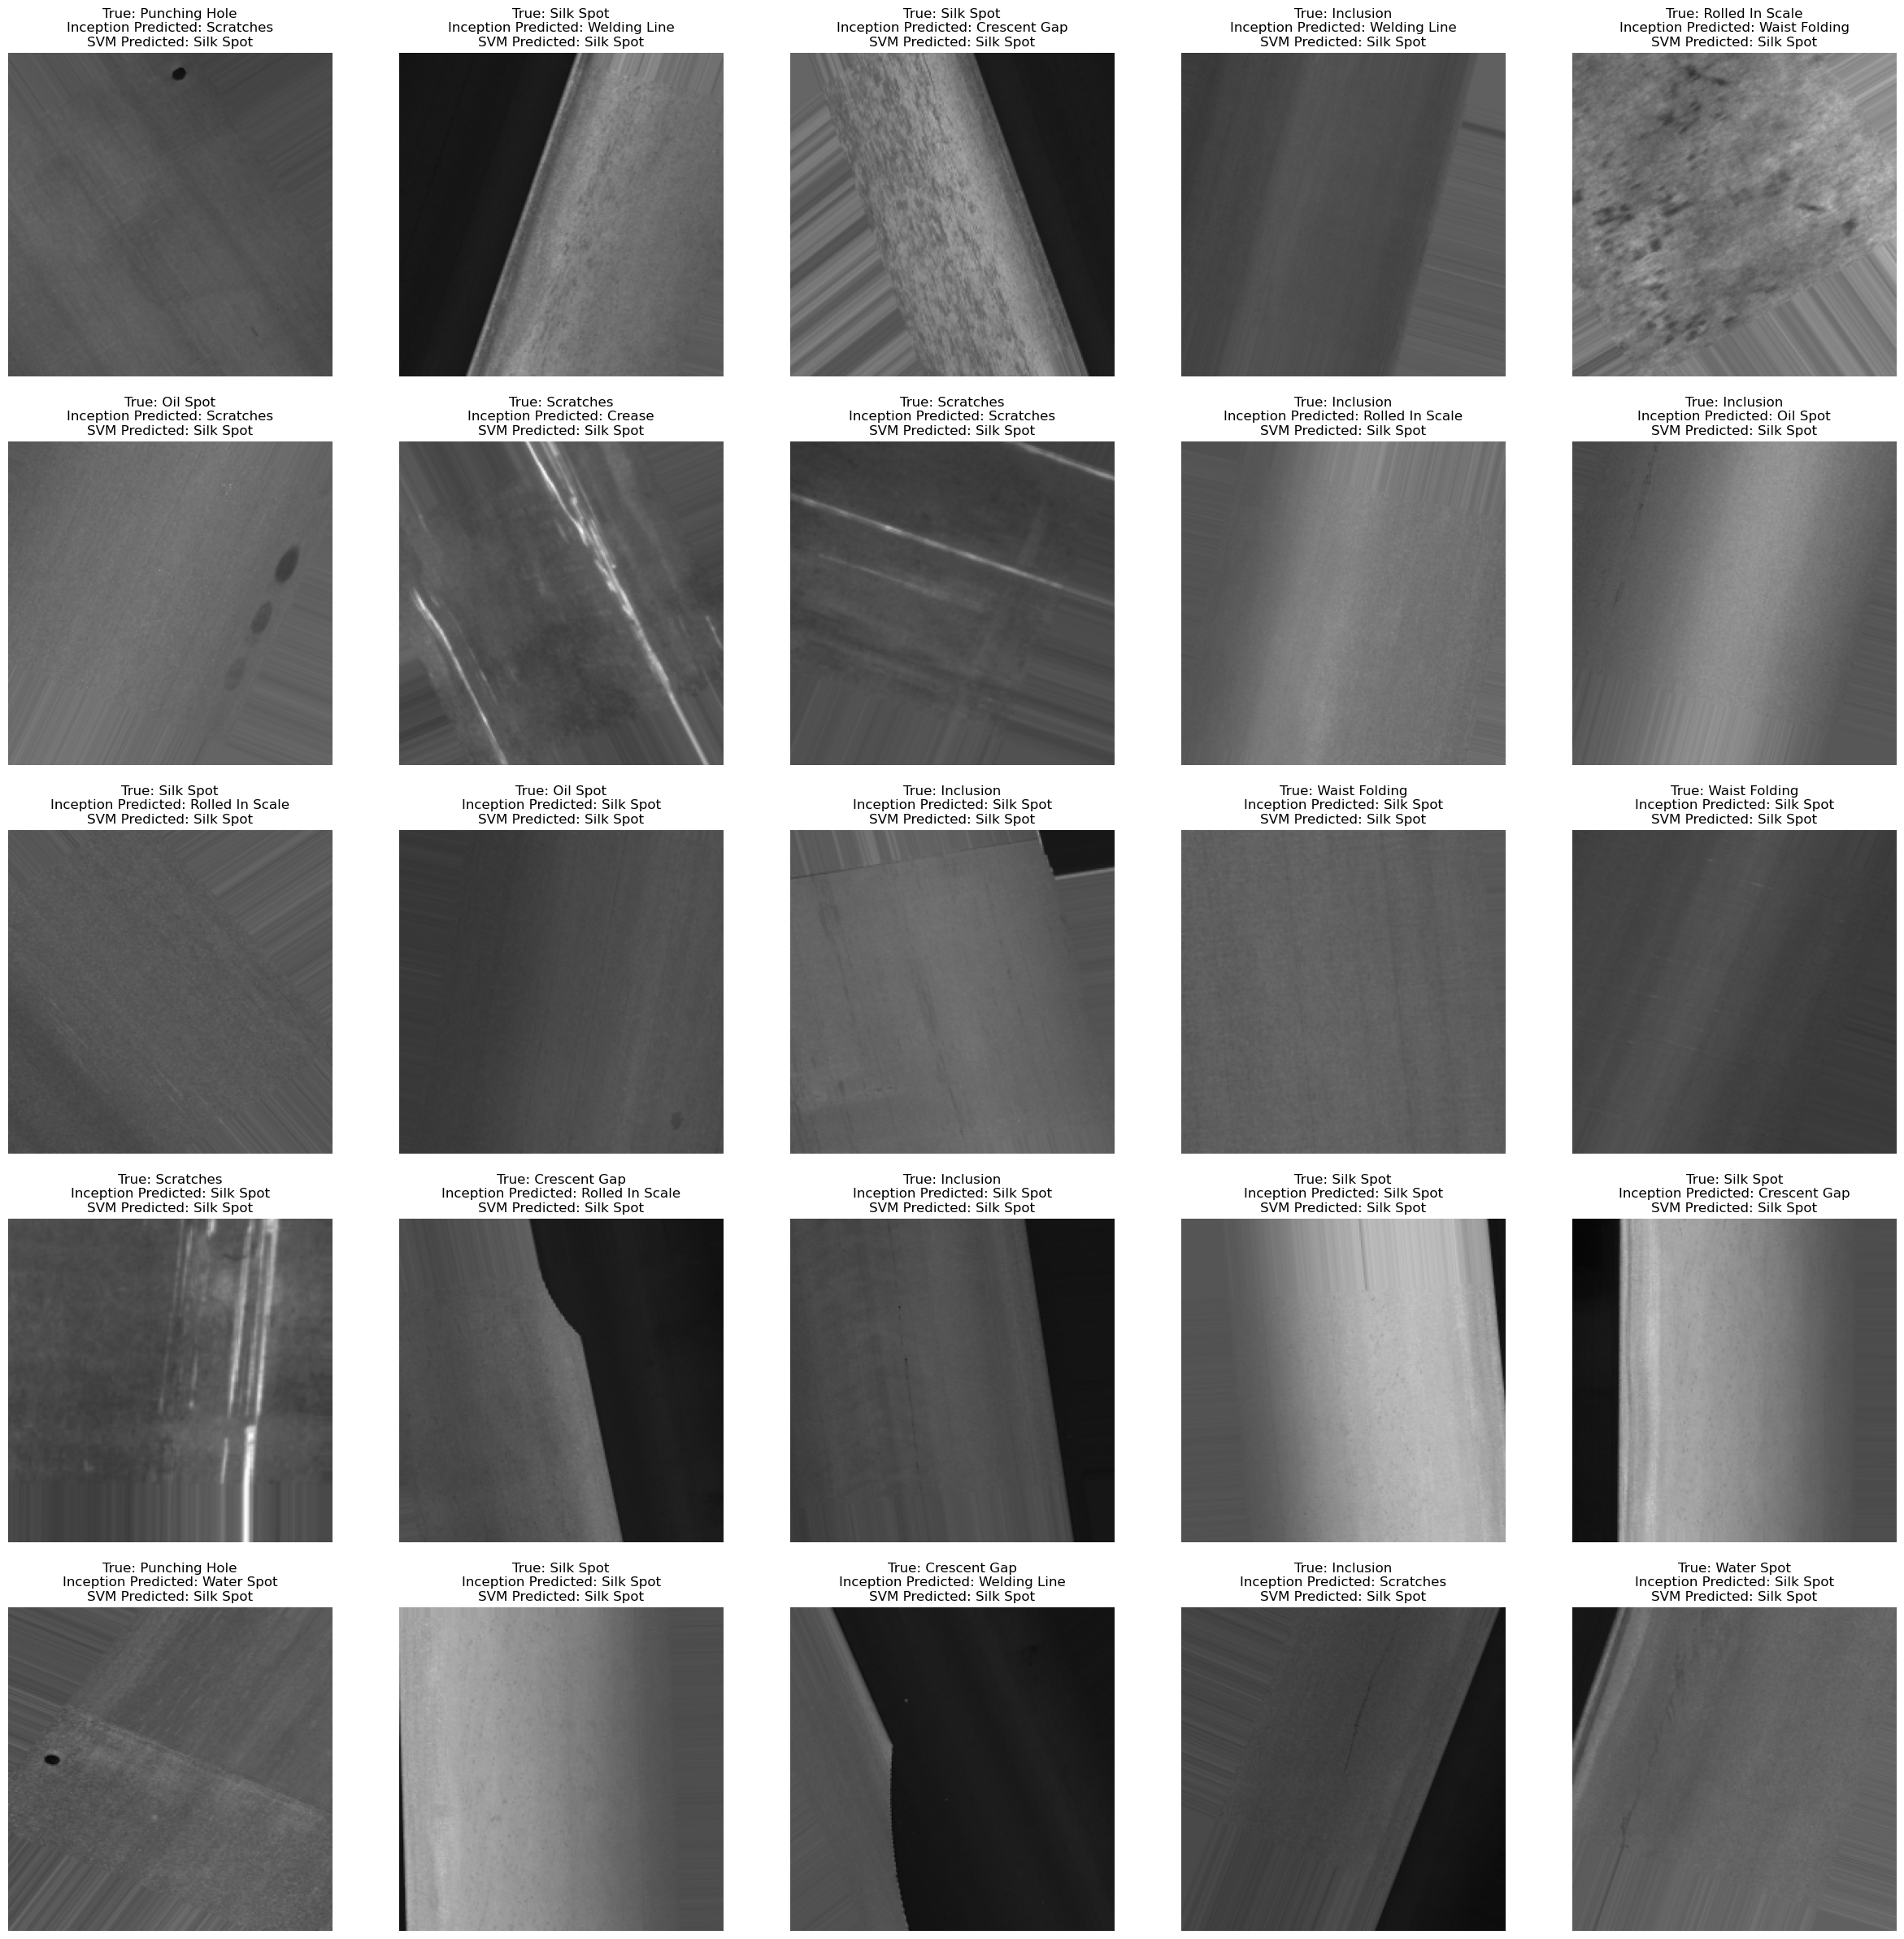

Total correct Inception predictions: 3
Total correct SVM predictions: 6


In [39]:
fig = plt.figure(figsize=(30, 30))
svm_correct_prediction = 0
inception_correct_prediction = 0
for i, image in enumerate(val_data_gen):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(image[0][0])
    ax.axis('off')
    true_class = class_names[np.argmax(image[1])]
    svm_predicted_class = class_names[svm_predictions[i]]
    inception_predicted_class = class_names[predicted_classes[i]]
    ax.set_title(f"True: {true_class}\nInception Predicted: {inception_predicted_class}\nSVM Predicted: {svm_predicted_class}")
    if true_class == svm_predicted_class:
        svm_correct_prediction += 1
    if true_class == inception_predicted_class:
        inception_correct_prediction += 1
    if i == 24:
        break
        
plt.show()

print(f"Total correct Inception predictions: {inception_correct_prediction}")
print(f"Total correct SVM predictions: {svm_correct_prediction}")
